<a href="https://www.kaggle.com/lovroselic/dna-segments-feb-2022-ls-v3?scriptVersionId=88418660" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

References:<br>
* https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense/notebook


# Setup

In [1]:
import time
from datetime import datetime

#measure notebook running time
start_time = time.time()

%matplotlib inline

import os, warnings
import numpy as np 
from numpy.random import seed
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from math import factorial

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, precision_score,recall_score, f1_score, classification_report, accuracy_score
from sklearn.cluster import KMeans

sns.set(style='white', context='notebook', palette='deep', rc={'figure.figsize':(10,8)})
print("loaded ...")

loaded ...


In [2]:
# Reproducibility
def set_seed(sd=13):
    seed(sd)
    np.random.seed(sd)
    os.environ['PYTHONHASHSEED'] = str(sd)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

RandomSeed = 13    
set_seed(RandomSeed)

In [3]:
%%time
train_data = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2022/train.csv')
test_data = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2022/test.csv')
submit_data = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2022/sample_submission.csv')

CPU times: user 20.7 s, sys: 1.23 s, total: 21.9 s
Wall time: 38.8 s


Well balanced set ...

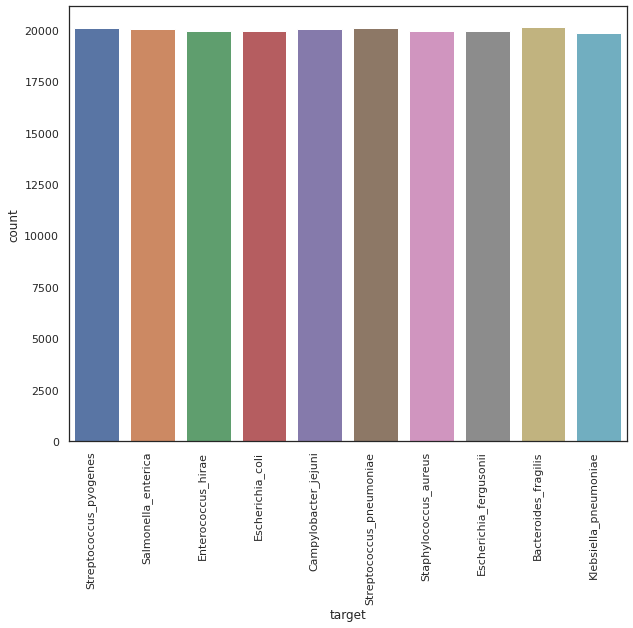

In [4]:
ax = sns.countplot(data=train_data, x='target');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right");

## Preparing sets

In [5]:
def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

In [6]:
LE = LabelEncoder()
TARGET = LE.fit_transform(train_data.target)
TRAIN = train_data.drop(['row_id','target'], axis = 1)
TEST = test_data.drop(['row_id'], axis = 1)

Formula taken from: https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense/notebook

In [7]:
%%time
TRAIN = pd.DataFrame({col: ((TRAIN[col] + bias_of(col)) * 1000000).round().astype(int) for col in TRAIN})
TEST = pd.DataFrame({col: ((TEST[col] + bias_of(col)) * 1000000).round().astype(int) for col in TEST})

CPU times: user 863 ms, sys: 150 ms, total: 1.01 s
Wall time: 1.01 s


In [8]:
GROUPED = TRAIN.copy()
GROUPED['target'] = train_data.target
GROUPED = GROUPED.groupby("target").mean()
GROUPED

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
target,,,,,,,,,,,,,,,,,,,,,
Bacteroides_fragilis,0.952331,4.946621,21.634341,34.089528,66.369283,98.520830,51.734396,39.520036,6.470877,1.065098,...,102.254233,424.976662,320.638711,458.832365,539.791847,325.692587,55.369631,87.503451,101.278465,0.549829
Campylobacter_jejuni,11.727359,5.905498,9.396202,21.523302,36.699098,51.557394,32.505657,23.521009,4.424912,1.229726,...,460.261078,1020.891891,614.660071,1354.235359,1951.390819,1328.442207,194.237851,279.639187,334.038778,0.472013
Enterococcus_hirae,0.053943,3.238883,10.055146,34.948012,39.066627,51.831905,33.237680,24.562591,5.008322,0.245852,...,284.024866,882.307114,614.182233,1025.539630,1128.882589,630.543591,113.233920,254.695593,252.063970,5.741415
Escherichia_coli,0.553212,3.607075,37.061229,136.083475,213.948041,235.996693,197.728480,111.965979,30.469987,0.831496,...,87.542289,178.280489,85.126115,240.376791,234.874486,133.210492,41.415472,16.331396,43.131175,0.135685
Escherichia_fergusonii,0.809751,3.395747,38.074535,99.218288,176.572955,189.281537,192.581582,117.783368,12.998796,1.841200,...,115.522897,151.801826,109.412148,220.035662,274.704770,135.966444,35.766063,12.431008,72.301399,0.137634
Klebsiella_pneumoniae,0.942158,25.367915,91.998992,401.304630,912.186527,1378.766060,1084.572228,404.182043,51.677029,8.575301,...,43.915101,101.733562,80.364891,199.976621,142.027107,118.780924,13.378395,18.501889,42.514889,0.196654
Salmonella_enterica,0.718472,5.630155,47.556865,241.511782,479.148178,499.543285,459.288517,258.867249,27.393709,4.399451,...,100.212981,158.710834,117.243135,211.061608,269.192961,143.963854,33.280280,15.361408,64.736745,0.404843
Staphylococcus_aureus,0.056250,3.836419,11.160269,22.002509,50.261629,56.387726,34.467158,24.303778,4.639119,1.341161,...,193.536956,440.146972,268.019720,682.623363,801.792162,715.755733,57.503437,85.572382,148.457725,0.140148
Streptococcus_pneumoniae,0.055345,4.557437,9.201754,22.900219,45.776975,53.651888,33.558085,24.378699,4.203248,0.349806,...,165.262529,398.263674,407.007871,476.632858,637.485005,335.395387,57.656122,95.094451,95.008469,3.534323


In [9]:
F = pd.melt(GROUPED, value_vars = GROUPED.columns, ignore_index = False)
F = F.reset_index()
F

,target,variable,value
0,Bacteroides_fragilis,A0T0G0C10,0.952331
1,Campylobacter_jejuni,A0T0G0C10,11.727359
2,Enterococcus_hirae,A0T0G0C10,0.053943
3,Escherichia_coli,A0T0G0C10,0.553212
4,Escherichia_fergusonii,A0T0G0C10,0.809751
...,...,...,...
2855,Klebsiella_pneumoniae,A10T0G0C0,0.196654
2856,Salmonella_enterica,A10T0G0C0,0.404843
2857,Staphylococcus_aureus,A10T0G0C0,0.140148
2858,Streptococcus_pneumoniae,A10T0G0C0,3.534323


CPU times: user 15.6 s, sys: 1.35 s, total: 16.9 s
Wall time: 16.8 s


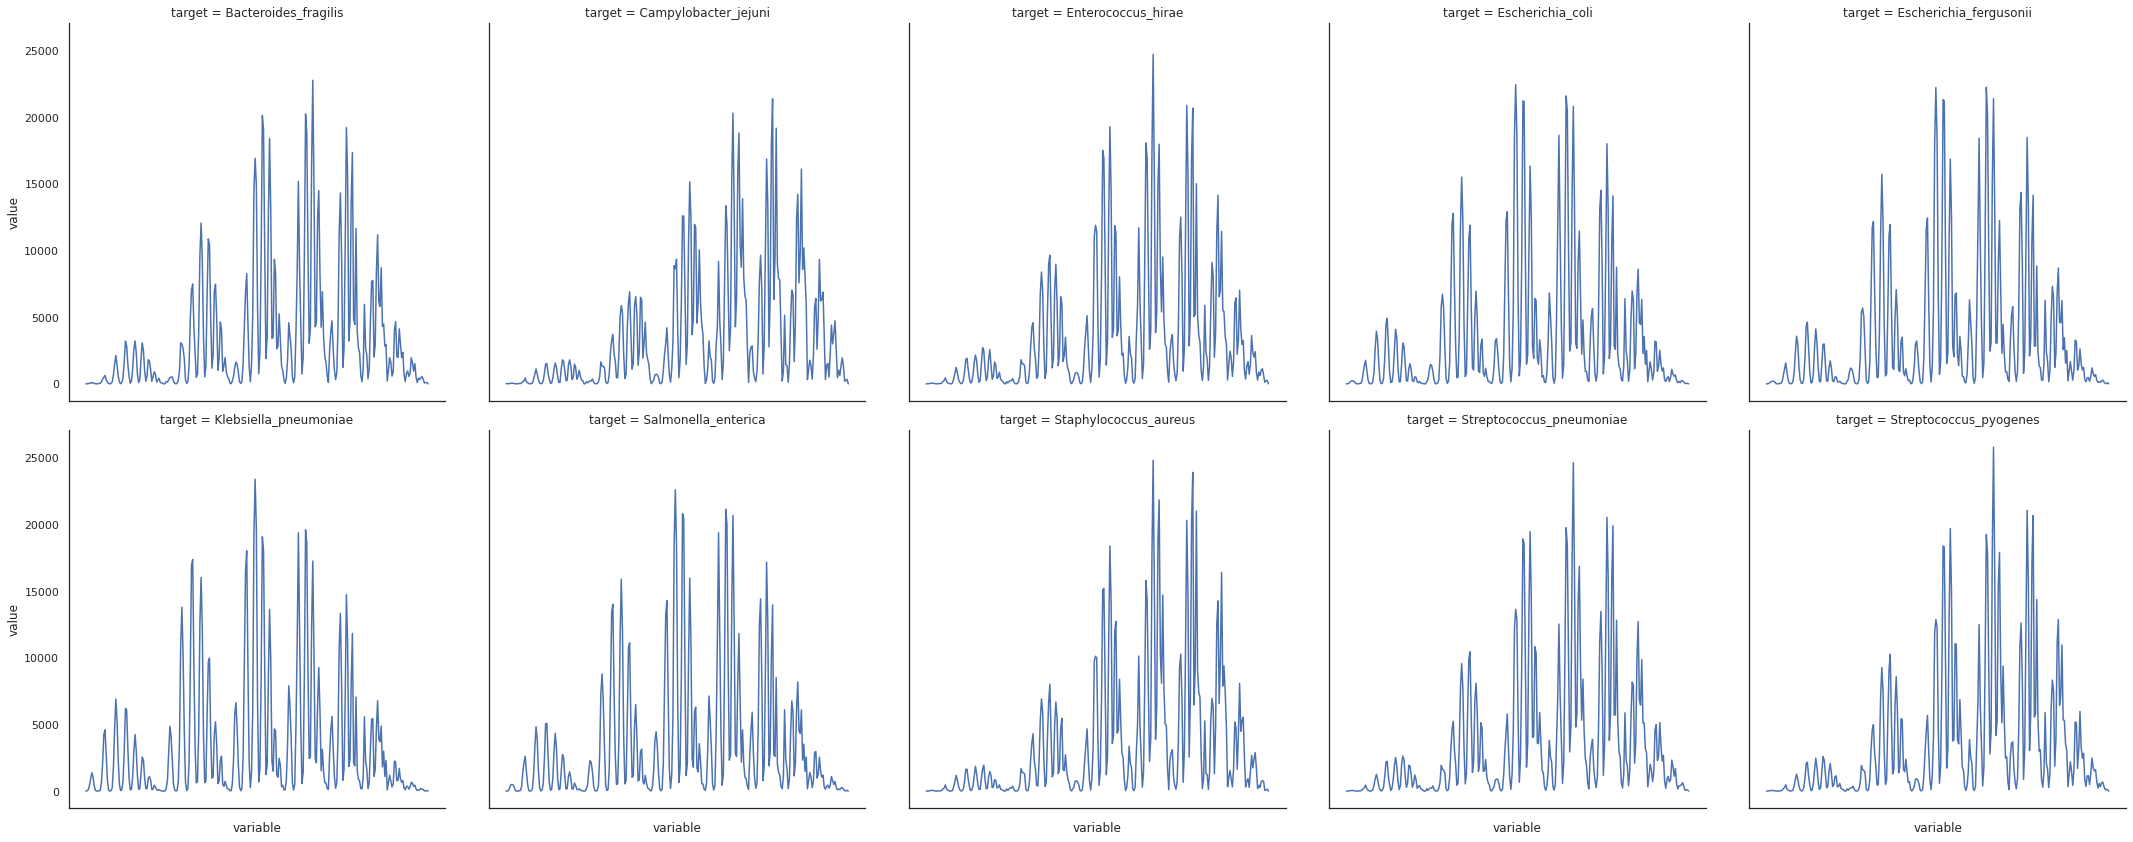

In [10]:
%%time
def plot(x,y, **kwargs):
    sns.lineplot(x=x,y=y);
    
g = sns.FacetGrid(F, col = 'target', col_wrap=5, sharex=True, sharey=True, height = 6);
g = g.map(plot, "variable", "value");
g.set(xticklabels=[]);

One example

<AxesSubplot:>

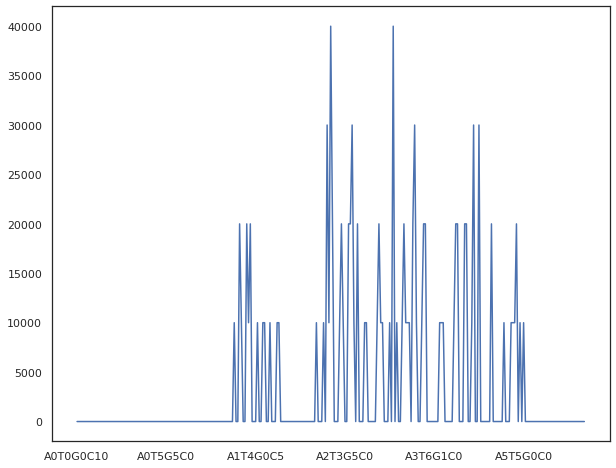

In [11]:
TRAIN.iloc[0,:-1].plot()

Greatest common divisor

In [12]:
TRAIN['GCD'] = TRAIN.apply(np.gcd.reduce, axis = 1)
TEST['GCD'] = TEST.apply(np.gcd.reduce, axis = 1)
# duplicates = TRAIN.duplicated()
# TRAIN = TRAIN[~duplicates]
# TARGET = TARGET[~duplicates]

Clustering

In [13]:
%%time
kmeans = KMeans(n_clusters = 10, random_state=RandomSeed)
TRAIN['cluster'] = kmeans.fit_predict(TRAIN)
TEST['cluster'] = kmeans.fit_predict(TEST)

CPU times: user 1min 41s, sys: 7.94 s, total: 1min 49s
Wall time: 57.9 s


In [14]:
scaler = StandardScaler()

In [15]:
%%time
TRAIN_CD = kmeans.fit_transform(TRAIN)
TRAIN_CD = scaler.fit_transform(TRAIN_CD)
TRAIN_CD = pd.DataFrame(TRAIN_CD, columns = [f"Centroid_{i}" for i in range(TRAIN_CD.shape[1])])
TEST_CD = kmeans.fit_transform(TEST)
TEST_CD = scaler.fit_transform(TEST_CD)
TEST_CD = pd.DataFrame(TEST_CD, columns = [f"Centroid_{i}" for i in range(TRAIN_CD.shape[1])])

CPU times: user 1min 45s, sys: 8.96 s, total: 1min 54s
Wall time: 1min 1s


In [16]:
TRAIN = TRAIN.join([TRAIN_CD])
TEST = TEST.join([TEST_CD])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(TRAIN, TARGET, test_size = 0.25, random_state = RandomSeed, stratify=TARGET)

# Models

## Random Forest

In [18]:
rf_params = {
    'n_jobs':-1,
    'random_state': RandomSeed,
    'n_estimators': 300,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'auto',
    'max_samples': None
}

In [19]:
rf_grid = {
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf':[1],
    'max_features': ['auto'],
    'max_samples': [None, 0.9],
    'n_estimators': [300],
}

In [20]:
# %%time
# rf_clf = RandomForestClassifier(**rf_params)
# rf_grid_clf = GridSearchCV(rf_clf, rf_grid, cv=3, scoring= "f1_micro")
# rf_grid_clf.fit(X_train, y_train)
# print(rf_grid_clf.best_estimator_)
# print(rf_grid_clf.best_params_)
# print(rf_grid_clf.best_score_)

In [21]:
# print("Reference score:",0.9639976772695013, 
#       " {'max_depth': None, 'max_features': 'auto', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300} ","\n")
# rf_scores = pd.DataFrame(rf_grid_clf.cv_results_['params'])
# rf_scores['results'] = rf_grid_clf.cv_results_['mean_test_score']
# rf_scores['std'] = rf_grid_clf.cv_results_['std_test_score']
# rf_scores = rf_scores.sort_values('results', ascending=False)
# rf_scores

In [22]:
%%time
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)
rf_train_score = rf_model.score(X_train, y_train)
rf_accuracy = rf_model.score(X_test, y_test)
print("Train: {:.2f} %".format(rf_train_score * 100))
print("Test: {:.2f} %".format(rf_accuracy*100))
print('Overfit: {:.2f} %'.format((rf_train_score-rf_accuracy)*100))

Train: 100.00 %
Test: 99.22 %
Overfit: 0.78 %
CPU times: user 8min 25s, sys: 1.33 s, total: 8min 27s
Wall time: 4min 27s


In [23]:
%%time
train_pred = rf_model.predict(X_train)
val_pred = rf_model.predict(X_test)
print(classification_report(y_test, val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5035
           1       0.99      0.99      0.99      5016
           2       0.99      0.99      0.99      4987
           3       0.99      0.99      0.99      4990
           4       0.99      0.99      0.99      4984
           5       0.99      1.00      1.00      4962
           6       0.99      0.99      0.99      5007
           7       0.99      0.99      0.99      4982
           8       0.99      0.99      0.99      5018
           9       0.99      0.99      0.99      5019

    accuracy                           0.99     50000
   macro avg       0.99      0.99      0.99     50000
weighted avg       0.99      0.99      0.99     50000

CPU times: user 28.5 s, sys: 262 ms, total: 28.8 s
Wall time: 15.7 s


In [24]:
cm = confusion_matrix(y_test, val_pred, normalize = 'pred')
cm_train = confusion_matrix(y_train, train_pred, normalize = 'pred')

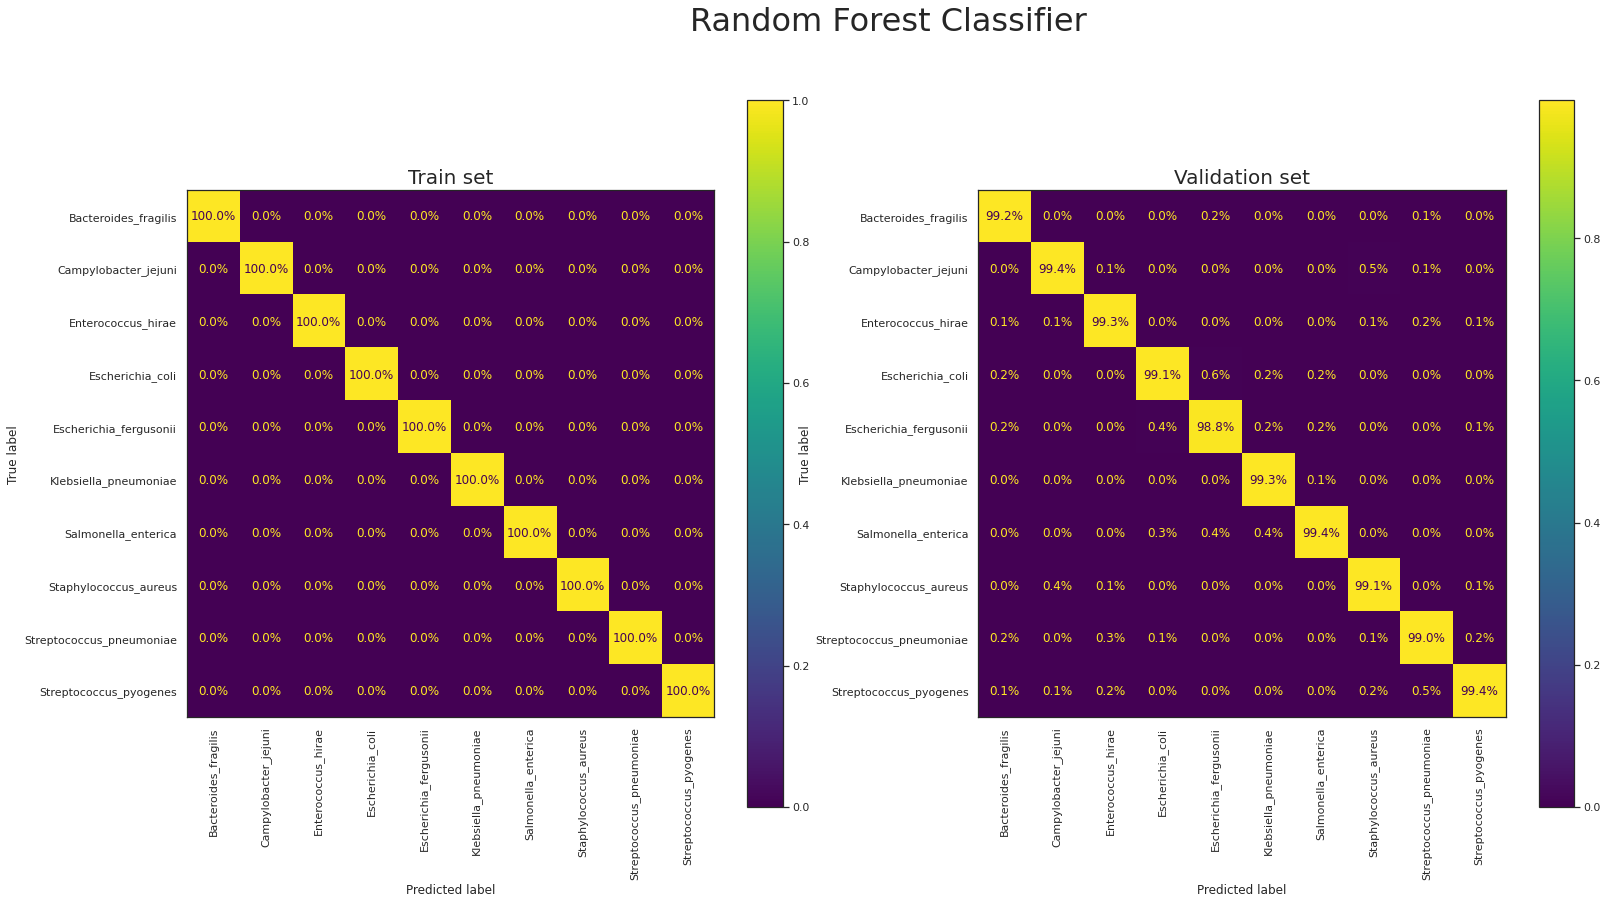

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,13))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels= LE.classes_);
disp_train.plot(ax=ax1, values_format='.1%', xticks_rotation='vertical');
disp_train.ax_.set_title('Train set', {'fontsize':20});

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= LE.classes_);
disp_test.plot(ax=ax2, values_format='.1%', xticks_rotation='vertical');
disp_test.ax_.set_title('Validation set',{'fontsize':20});
fig.suptitle('Random Forest Classifier', fontsize=32);

---

---

## Extra Trees

In [26]:
ET_parameters = {
    'random_state': RandomSeed,
    'bootstrap': True,
    'n_estimators': 300,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 0.8,
}

In [27]:
ex_param_grid = {"max_depth": [None], 
                 'max_features':[0.8], 
                 'n_estimators': [300],
                 'min_samples_split': [2],
                 'min_samples_leaf': [1],
                 'bootstrap': [True]
                }

In [28]:
# %%time
# ETC_clf = ExtraTreesClassifier(**ET_parameters)
# etc_gs = GridSearchCV(estimator = ETC_clf, param_grid = ex_param_grid, scoring='f1_micro', n_jobs=-1,verbose = 10, cv=3)
# etc_gs.fit(X_train, y_train)

# print("Best score:", etc_gs.best_score_)
# print("Best params:", etc_gs.best_params_)
# print("Best estimator:", etc_gs.best_estimator_)

In [29]:
# print("best score:", 0.9867933333333333,
#      "{'max_depth': None, 'max_features': 0.8, 'n_estimators': 300} \n")
# etc_scores = pd.DataFrame(etc_gs.cv_results_['params'])
# etc_scores['results'] = etc_gs.cv_results_['mean_test_score']
# etc_scores['std'] = etc_gs.cv_results_['std_test_score']
# etc_scores = etc_scores.sort_values('results', ascending=False)
# etc_scores

In [30]:
%%time
ETC_model = ExtraTreesClassifier(**ET_parameters)
ETC_model.fit(X_train, y_train)
ETC_train_score = ETC_model.score(X_train, y_train)
ETC_accuracy = ETC_model.score(X_test, y_test)
print("Train: {:.2f} %".format(ETC_train_score*100))
print("Test: {:.2f} %".format(ETC_accuracy*100))
print('Overfit: {:.2f} %'.format((ETC_train_score-ETC_accuracy)*100))

Train: 100.00 %
Test: 99.20 %
Overfit: 0.80 %
CPU times: user 15min 24s, sys: 1.05 s, total: 15min 25s
Wall time: 15min 28s


In [31]:
%%time
train_pred = ETC_model.predict(X_train)
val_pred = ETC_model.predict(X_test)
print(classification_report(y_test, val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5035
           1       0.99      0.99      0.99      5016
           2       0.99      0.99      0.99      4987
           3       0.99      0.99      0.99      4990
           4       0.99      0.99      0.99      4984
           5       1.00      1.00      1.00      4962
           6       0.99      0.99      0.99      5007
           7       0.99      0.99      0.99      4982
           8       0.99      0.99      0.99      5018
           9       0.99      0.99      0.99      5019

    accuracy                           0.99     50000
   macro avg       0.99      0.99      0.99     50000
weighted avg       0.99      0.99      0.99     50000

CPU times: user 20.6 s, sys: 143 ms, total: 20.8 s
Wall time: 20.8 s


In [32]:
cm = confusion_matrix(y_test, val_pred, normalize = 'pred')
cm_train = confusion_matrix(y_train, train_pred, normalize = 'pred')

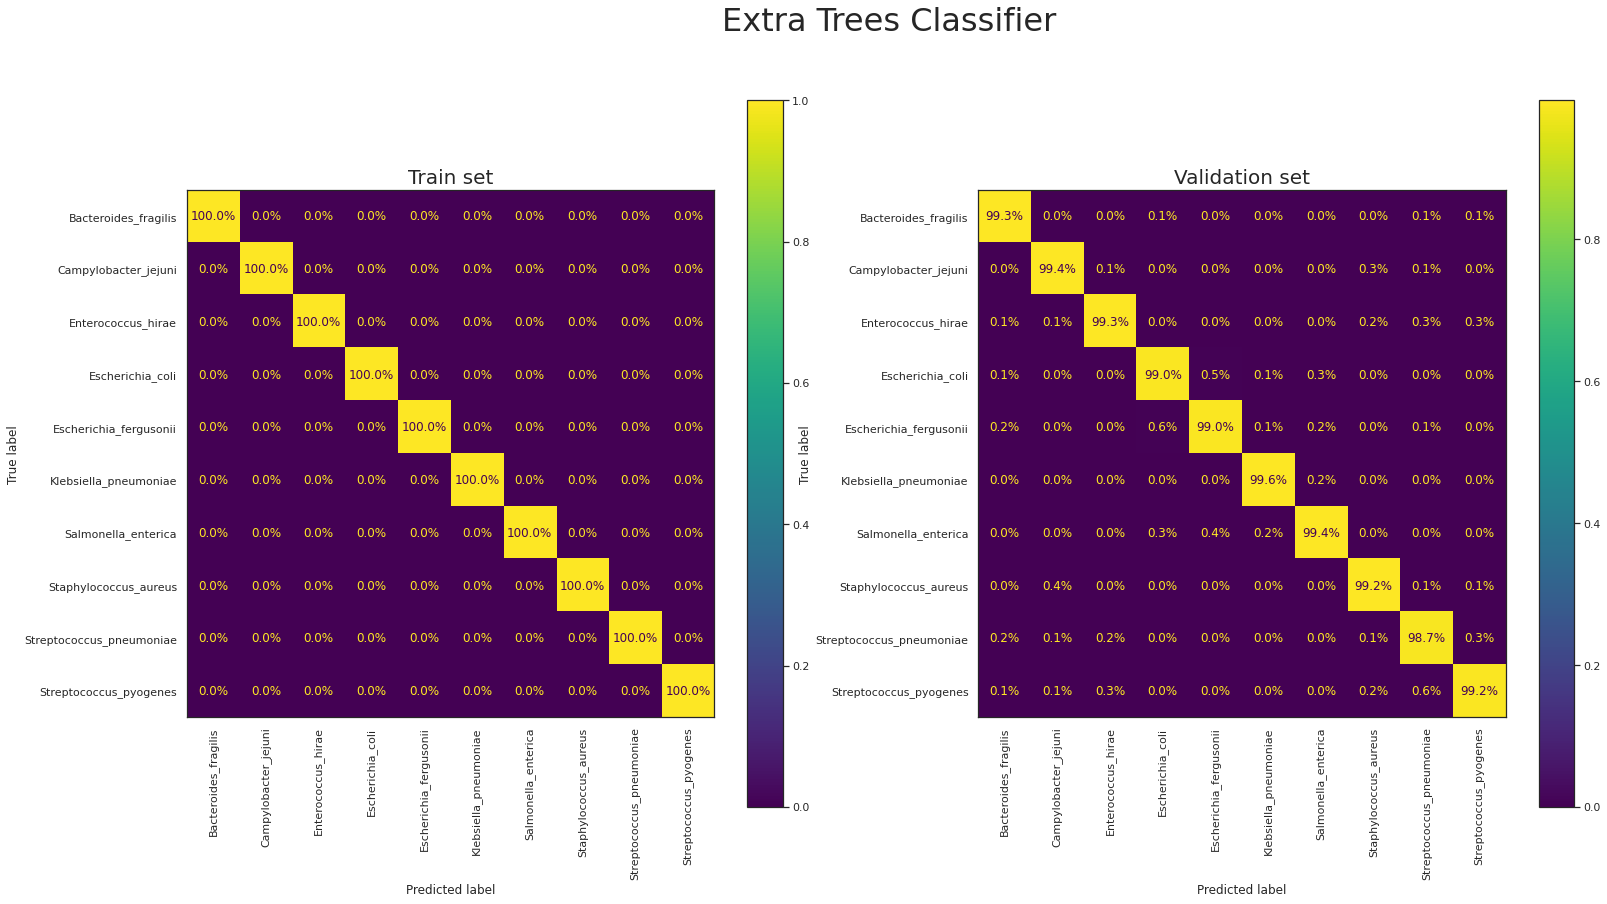

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,13))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels= LE.classes_);
disp_train.plot(ax=ax1, values_format='.1%', xticks_rotation='vertical');
disp_train.ax_.set_title('Train set', {'fontsize':20});

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= LE.classes_);
disp_test.plot(ax=ax2, values_format='.1%', xticks_rotation='vertical');
disp_test.ax_.set_title('Validation set',{'fontsize':20});
fig.suptitle('Extra Trees Classifier', fontsize=32);

# Predictions

In [34]:
%%time
etc_predictions = LE.inverse_transform(ETC_model.predict(TEST).astype('int'))
rf_predictions = LE.inverse_transform(rf_model.predict(TEST).astype('int'))

CPU times: user 22.3 s, sys: 191 ms, total: 22.5 s
Wall time: 16.3 s


## Soft Voting Classifier
using:<br>
* Extra Trees
* RF

In [35]:
etc_proba = ETC_model.predict_proba(TEST)
rf_proba = rf_model.predict_proba(TEST)

In [36]:
all_proba_mean = np.mean(np.array([rf_proba,etc_proba]), axis = 0)

In [37]:
pd.options.display.float_format = '{:,.3f}'.format
PROBA = pd.DataFrame(all_proba_mean, index = submit_data.row_id, columns = LE.classes_)
PROBA.head(10)

,Bacteroides_fragilis,Campylobacter_jejuni,Enterococcus_hirae,Escherichia_coli,Escherichia_fergusonii,Klebsiella_pneumoniae,Salmonella_enterica,Staphylococcus_aureus,Streptococcus_pneumoniae,Streptococcus_pyogenes
row_id,,,,,,,,,,
200000,0.138,0.003,0.022,0.230,0.485,0.007,0.037,0.012,0.027,0.040
200001,0.165,0.003,0.027,0.122,0.158,0.122,0.303,0.010,0.045,0.045
200002,0.092,0.018,0.492,0.005,0.027,0.002,0.005,0.063,0.090,0.207
200003,0.032,0.008,0.008,0.072,0.058,0.020,0.773,0.003,0.012,0.013
200004,0.078,0.192,0.088,0.015,0.017,0.000,0.007,0.468,0.067,0.068
200005,0.113,0.005,0.020,0.188,0.542,0.007,0.062,0.005,0.025,0.033
200006,0.115,0.010,0.012,0.153,0.127,0.112,0.415,0.012,0.023,0.022
200007,0.048,0.202,0.113,0.012,0.018,0.002,0.003,0.443,0.058,0.100
200008,0.232,0.048,0.130,0.022,0.043,0.003,0.008,0.037,0.323,0.153


In [38]:
vc_predictions = LE.inverse_transform(np.argmax(all_proba_mean, axis = 1))

# Compare

In [39]:
compare = submit_data.copy().drop("target", axis=1)
compare['ETC'] = etc_predictions
compare['RF'] = rf_predictions
compare['VC'] = vc_predictions
compare.head(10)

,row_id,ETC,RF,VC
0,200000,Escherichia_fergusonii,Escherichia_fergusonii,Escherichia_fergusonii
1,200001,Salmonella_enterica,Salmonella_enterica,Salmonella_enterica
2,200002,Enterococcus_hirae,Enterococcus_hirae,Enterococcus_hirae
3,200003,Salmonella_enterica,Salmonella_enterica,Salmonella_enterica
4,200004,Staphylococcus_aureus,Staphylococcus_aureus,Staphylococcus_aureus
5,200005,Escherichia_fergusonii,Escherichia_fergusonii,Escherichia_fergusonii
6,200006,Salmonella_enterica,Salmonella_enterica,Salmonella_enterica
7,200007,Staphylococcus_aureus,Staphylococcus_aureus,Staphylococcus_aureus
8,200008,Streptococcus_pneumoniae,Streptococcus_pneumoniae,Streptococcus_pneumoniae
9,200009,Staphylococcus_aureus,Bacteroides_fragilis,Bacteroides_fragilis


# Submission

In [40]:
#submit_data.target = etc_predictions
#submit_data.target = rf_predictions

#best
submit_data.target = vc_predictions
submit_data.head(10)

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus
5,200005,Escherichia_fergusonii
6,200006,Salmonella_enterica
7,200007,Staphylococcus_aureus
8,200008,Streptococcus_pneumoniae
9,200009,Bacteroides_fragilis


In [41]:
#output
submit_data.to_csv('submission.csv', index=False)
print("Submission was successfully saved!")

Submission was successfully saved!


In [42]:
end_time = time.time()
print("Notebook run time: {:.1f} minutes. Finished at {}".format((end_time - start_time)/60, datetime.now()) )

Notebook run time: 24.6 minutes. Finished at 2022-02-21 21:17:24.584778
